In [1]:
%matplotlib notebook
from QDP import qdp
import os.path
import numpy as np
from scipy.stats import poisson
import h5py
import matplotlib.pyplot as plt
import math
from scipy.optimize import leastsq,curve_fit

In [7]:
#analysis_master_path='Y:/Rb/Analysis/' # Y:\ is network drive connected to Hexagon E:\Rb\

exp_id='2018_03_03_00_08_56_Open loop Microwave Ramsey with 780A, r1-r2, Tgap=1.8us, N=500'
data_master_path='D:/Data/' # D:\ is local SSD in the main experiment computer
analysis_master_path='D:/Analysis/' # D:\ is local SSD in the main experiment computer
exp_date="_".join(exp_id.split("_")[:3]) # Date folder name automatically generated from exp name.
exp_path=data_master_path+exp_date+'/'+exp_id+'/'

# if not os.path.exists(analysis_master_path+exp_path):
#     os.makedirs(analysis_master_path+exp_path)
    
experiment_file='results.hdf5'
dp=exp_path
cuts = [[450],[450],[450]]

q = qdp.QDP(base_data_path=dp)
q.load_data_file(experiment_file)
for r in range(5):
    q.set_thresholds(cuts, roi=r)

In [3]:
print q.experiments[0]['variable_list']
xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
retention = q.apply_thresholds()
print q.get_retention()['retention']

[u'zz_outermost_iteration']
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading o

QDP\qdp.py:242: RuntimeWarning: invalid value encountered in divide
  e['iterations'][i]['retention'] = retention/loaded
QDP\qdp.py:85: RuntimeWarning: invalid value encountered in sqrt
  errs[r] = (z/n[r].astype('float'))*np.sqrt(ns[r].astype('float')*(1.0-ns[r].astype('float')/n[r].astype('float')))


In [11]:
import cPickle
file=open(exp_id+'.txt','w')
file.write(cPickle.dumps(q))
file.close()

    Save & load from numpy

In [ ]:
#exp_id='2018_02_07_00_08_36_Open loop Ramsey with Ryd 780A, parked r1-r2, reduced FORT depth, fixed t_gap'
# I'm saving retention to npy array.
for key in ['retention','ivar','error']:
    np.save(exp_id+key,q.get_retention()[key])


Plotting retentions

In [ ]:
savefig=True
colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
fig, ax = plt.subplots()
fig.set_size_inches(6,4)
fit_guesses=[30,0.4,2,0,0.5]
roi_dependency=[0,0,0,0,0]
fitted_parameters=[]
for roi in [1,2]:
    error=0
    data = []
    reten = []
    err = []
    for e in range(len(np.squeeze(retention['ivar']))):
        data.append(np.squeeze(retention['ivar'])[e][roi])
        reten.append(np.squeeze(retention['retention'])[e][roi])
        err.append(np.squeeze(retention['error'])[e][roi])
    ax.errorbar(data,reten,yerr=err,label="ROI:{}".format(roi),fmt='o',markersize=3,color=colors[roi],capsize=1)
#     guesses=np.add(fit_guesses,np.ones(len(fit_guesses))*(roi-2)*roi_dependency)
#     try:
#         fit,pcov = curve_fit(decaying_sin,data,reten,guesses)
#     except RuntimeError:
#         error=1
#     if error is not 1:
#         print "ROI:{}, tau : {}, amplitude {} , freq:{}, phase:{}, offset:{}".format(roi,fit[0],fit[1],fit[2],fit[3],fit[4])
#         fitted_parameters.append(fit[0])
#         xarray=np.linspace(np.min(data),np.max(data),100)
#         yfit=decaying_sin(xarray, fit[0],fit[1],fit[2],fit[3],fit[4])
#         plt.plot(xarray,yfit,label="ROI:{}".format(roi),color=colors[roi])

plt.show()
ax.set_title(exp_id)
ax.set_ylim(0, 1.05)
ax.set_xlim(-0.5,)
ax.grid()
#ax.set_xlabel(xlab)
ax.set_xlabel('Feedback iteration #')
ax.set_ylabel('retention')
ax.legend()
if savefig:
    fig.savefig(exp_id+'atom_Retention.pdf')
    fig.savefig(exp_id+'atom_Retention.png')

In [ ]:
Estimation of freq change

In [15]:
def sin(t,amp,freq,phase,offset):
    res = (amp*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def decaying_sin(t,tau,amp,freq,phase,offset): # decaying sinusoidal
    res = (amp*np.exp(-t/tau)*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def est_freq(ydata,tgap,tau,amp,freq,phase,offset): # Estimation of frequency change (from dy/df where y=sinusoidal fit)
    res=(ydata-decaying_sin(tau,tgap,amp,freq,phase,offset))/(amp*np.exp(-tgap/tau)*2*np.pi*tgap*np.cos(2*np.pi*freq*tgap+phase))
    return res

def sin_fit(datax,datay):
    [fit,p] = curve_fit(sin,datax,datay,[0.4,1,-0.19,1])
    return fit

In [16]:
# Using fitted values from expid=2018_02_06_23_42_45_Open loop Ramsey with Ryd 780A, parked r1-r2, reduced FORT depth
fitted_parameters=[]
fitted_parameters.append([  4.93343057e-03,   3.82604911e-01,   4.13198321e+02, 9.33769591e-01,   3.78585832e-01])
fitted_parameters.append([  2.06776635e-03,   3.52555019e-01,   4.88613428e+02, 7.63306893e-01,   4.28047354e-01])

tgap=0.0018

def freq_diff(roi,y):
    if roi==1:
        result=est_freq(y,tgap,fitted_parameters[0][0],
                        fitted_parameters[0][1],
                        fitted_parameters[0][2],
                        fitted_parameters[0][3],
                        fitted_parameters[0][4]
                       )
    elif roi==2:
        result=est_freq(y,tgap,fitted_parameters[1][0],
                        fitted_parameters[1][1],
                        fitted_parameters[1][2],
                        fitted_parameters[1][3],
                       fitted_parameters[1][4]
                       )
    return result

<IPython.core.display.Javascript object>


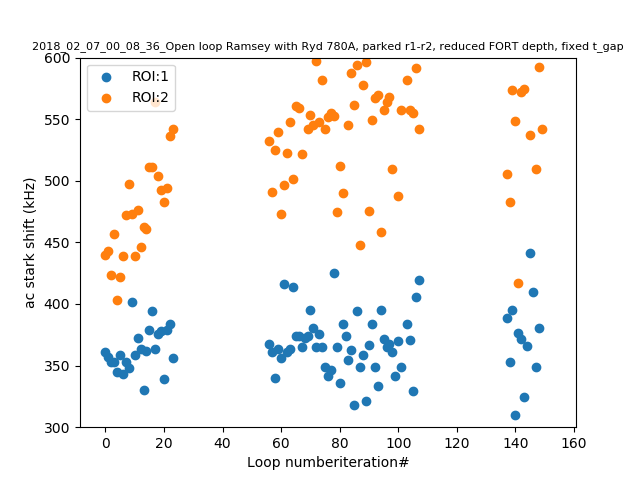

In [17]:
fig, ax = plt.subplots()

e=0 # experiment 0
for roi in [1,2]:
    ydata=fitted_parameters[roi-1][2]+freq_diff(roi, retention['retention'][e][:,roi])
    data = retention['ivar'][e][:,roi]
    ax.scatter(data,ydata,label="ROI:{}".format(roi))
plt.title(exp_id,fontsize=8)
plt.show()
ax.set_ylim(300, 600)
ax.set_xlabel(xlab+"iteration#")
ax.set_ylabel('ac stark shift (kHz)')
ax.legend()

<IPython.core.display.Javascript object>


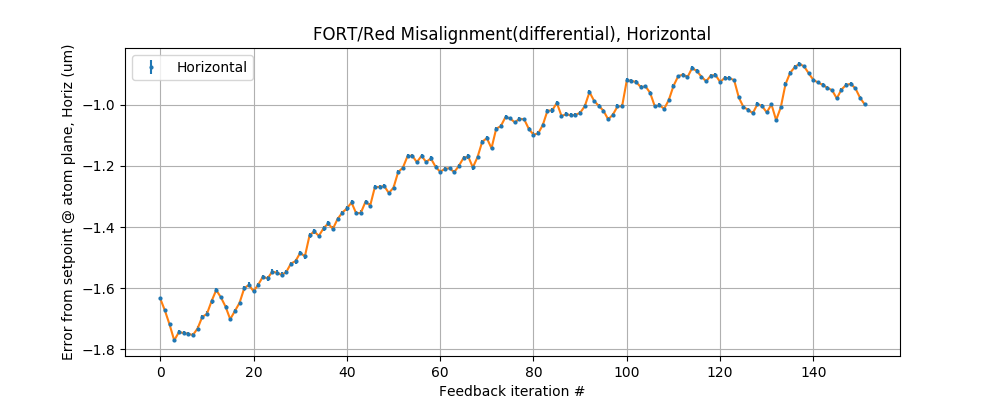

152
152


<IPython.core.display.Javascript object>


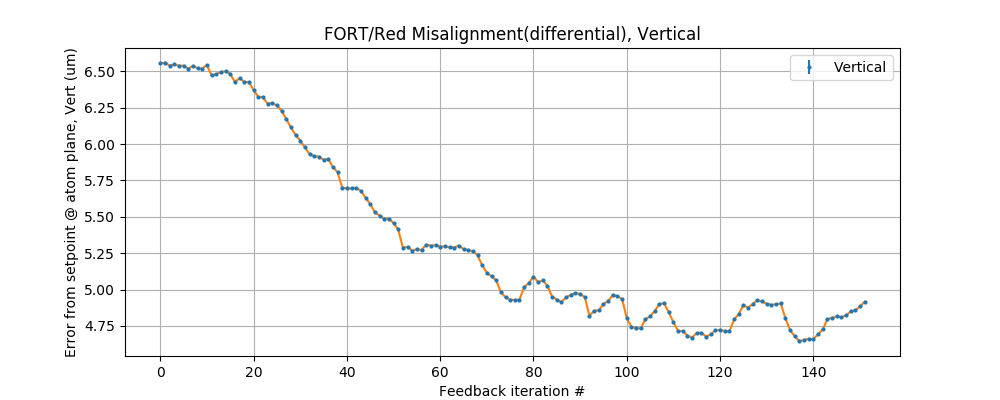

<IPython.core.display.Javascript object>


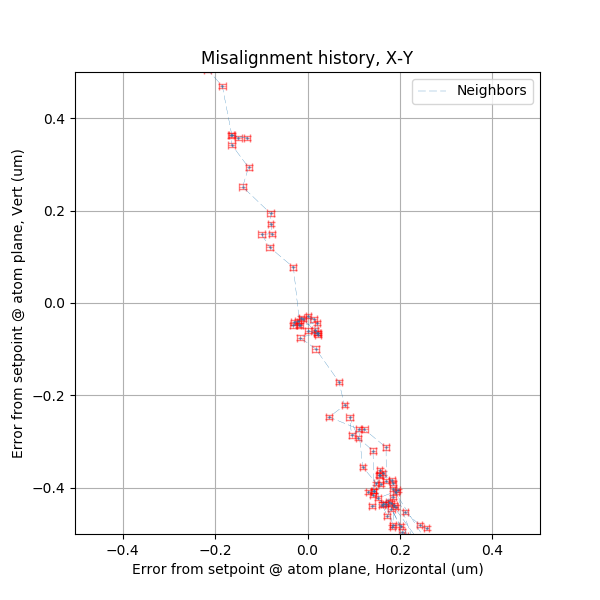

In [21]:
savefig=False
figW=10
figH=4
whichside='AAS_redside' #'AAS_
#whichside='AAS_redside'
fig, ax = plt.subplots()
fig.set_size_inches(figW,figH)
xdata = []
ydata = []
yerr = []
target=np.array([-100,-48])
sample_numbers=500
user_specified=152
iteration_range=range(min(len(np.squeeze(retention['ivar'])),user_specified))
for e in iteration_range:
    xdata.append(np.squeeze(retention['ivar'])[e][2])
    ydata.append(q.experiments[0]['iterations'][e][whichside]['x'])
    yerr.append(q.experiments[0]['iterations'][e][whichside]['sigma_x'])
print np.size(xdata)    
print np.size(ydata)
offset=target[0]#np.mean(ydata)
Xcoord=ydata-offset
Xcoord_err=yerr
ax.errorbar(xdata,Xcoord,yerr=np.array(yerr)/(np.sqrt(sample_numbers)),fmt='o',markersize=2,label='Horizontal')
ax.plot(xdata,Xcoord)

plt.show()
#ax.set_title(exp_id)
ax.set_title('FORT/Red Misalignment(differential), Horizontal')
#ax.set_xlim(0,130)
#ax.set_ylim(-10, 10)
ax.set_xlabel(xlab)
ax.set_ylabel('Error from setpoint @ atom plane, Horiz (um)')
ax.grid()
ax.legend()
ax.set_xlabel('Feedback iteration #')
if savefig:
    fig.savefig(exp_id+'Camera_X.pdf')
    fig.savefig(exp_id+'Camera_X.png')

fig, ax = plt.subplots()
fig.set_size_inches(figW,figH)
xdata = []
ydata = []
yerr = []
iteration_range=range(min(len(np.squeeze(retention['ivar'])),user_specified))
for e in iteration_range:
    xdata.append(np.squeeze(retention['ivar'])[e][2])
    ydata.append(q.experiments[0]['iterations'][e][whichside]['y'])
    yerr.append(q.experiments[0]['iterations'][e][whichside]['sigma_y'])
offset=target[1]
Ycoord=ydata-offset
Ycoord_err=yerr
ax.set_title('FORT/Red Misalignment(differential), Vertical')
ax.errorbar(xdata,Ycoord,yerr=np.array(yerr)/(np.sqrt(sample_numbers)),fmt='o',markersize=2,label='Vertical')
ax.plot(xdata,Ycoord)

#ax.set_title(exp_id)
#ax.set_xlim(0,130)
#ax.set_ylim(11.6, 13)
ax.set_xlabel(xlab)
ax.set_ylabel('Error from setpoint @ atom plane, Vert (um)')
ax.grid()
ax.legend()
ax.set_xlabel('Feedback iteration #')
if savefig:
    fig.savefig(exp_id+'Camera_Y.pdf')
    fig.savefig(exp_id+'Camera_Y.png')

fig, ax = plt.subplots()
fig.set_size_inches(6,6)
length_conversion=1.0 # Red gives already in um units
cutoff=-1
xdata=length_conversion*(Xcoord[0:cutoff]-np.nanmean(Xcoord))
xerr=length_conversion*np.array(Xcoord_err[0:cutoff])/math.sqrt(sample_numbers)
ydata=length_conversion*(Ycoord[0:cutoff]-np.nanmean(Ycoord))
yerr=length_conversion*np.array(Ycoord_err[0:cutoff])/math.sqrt(sample_numbers)
ax.errorbar(xdata,ydata,xerr=xerr,yerr=yerr,fmt='o',ecolor='red',elinewidth=0.5,markersize=1,capsize=3,alpha=0.5)
ax.plot(xdata,ydata,'--',linewidth=0.2,label='Neighbors')

ax.set_title('Misalignment history, X-Y')
ax.set_xlim(-0.5,0.5)
ax.set_ylim(-0.5,0.5)
ax.set_xlabel('Error from setpoint @ atom plane, Horizontal (um)')
ax.set_ylabel('Error from setpoint @ atom plane, Vert (um)')
ax.set_aspect('equal', 'datalim')
ax.grid()
ax.legend()
if savefig:
    fig.savefig(exp_id+'Camera Beam history.pdf')
    fig.savefig(exp_id+'Camera Beam history.png')